In [ ]:
# https://www.kaggle.com/code/sahityasetu/topic-modelling-on-reviews-dataset

In [1]:
!pip install -q contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 7.3 MB/s eta 0:00:00


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
pd.set_option('display.max_column',None)

import re
import string
import contractions
import spacy
nlp = spacy.load('en_core_web_sm')
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read dataset
dataset = pd.read_csv('/content/drive/MyDrive/DL - Dataset/Product_Reviews.csv')

In [4]:
# data sample
dataset.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,manufacturer,manufacturerNumber,name,prices,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-08-08T00:00:00.000Z,NaN,139.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-09-01T00:00:00.000Z,NaN,126.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-07-20T00:00:00.000Z,NaN,69.0,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2017-06-16T00:00:00.000Z,NaN,2.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2016-08-11T00:00:00.000Z,NaN,17.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [5]:
# data shape
row, col = dataset.shape
print(f'Dataset contains {row} Reviews and {col} Features.')

Dataset contains 1597 Reviews and 27 Features.


In [6]:
# data information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

In [7]:
# keeping only relevant columns
data = dataset[['reviews.text','reviews.title']]

# data sample
data.head()

,reviews.text,reviews.title
0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!"
1,Allow me to preface this with a little history...,One Simply Could Not Ask For More
2,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader
3,I bought one of the first Paperwhites and have...,Love / Hate relationship
4,I have to say upfront - I don't like coroporat...,I LOVE IT


In [8]:
# rename columns
data.rename(columns={'reviews.text':'Reviews','reviews.title':'Title'}, inplace=True)

# data sample
data.head()

,Reviews,Title
0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!"
1,Allow me to preface this with a little history...,One Simply Could Not Ask For More
2,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader
3,I bought one of the first Paperwhites and have...,Love / Hate relationship
4,I have to say upfront - I don't like coroporat...,I LOVE IT


In [9]:
# cheking missing values
data.isnull().sum()

,0
Reviews,0
Title,17


In [10]:
# checking empty string in Review column
len(data[data['Reviews'] == ''])

0

In [11]:
# 10 random previews
idx = np.random.randint(0, len(data),10)
for i in range(len(idx)):
  print(data['Reviews'][idx[i]])
  print('-'*50)

The Amazon tap I like other then I wish you could just say her name and she would respond. Sounds great when playing music
--------------------------------------------------
We love it. Bought one for family room and the office. Easy to install and use. LOVE all of the options for things to watch.
--------------------------------------------------
I already own the Amazon Echo, so for smart speaker, it is one of the most handy devices out there. There is so many things you will find that you can do with it and the list keeps growing. Since the software update that allows you to use "Always On" voice commands like its big brother, it has become my go to device.Pros:- Wireless Bluetooth Smart Speaker - I take it to work and use it in the car, even when I travel for work- Sync's up with my popular music aps (Spotify, Pandora, etc)- Alexa is very responsive and can answer your questions quickly- The best Alarm Clock- I sync up with audio books and will use it on long car rides or business 

### Prepare the text for topic modelling

In [13]:
# function to clean the review text
def clean_text(text):
  # lowercase
  text = text.lower()

  # fix contractions
  text = contractions.fix(text)

  # Remove special characters
  text = re.sub('\W+',' ',text)
  text = re.sub('\d+','',text)

  return text

In [14]:
# apply clean_text function to data
data['clean_reviews'] = data['Reviews'].apply(lambda x:clean_text(x))

# data sample
data.head()

,Reviews,Title,clean_reviews
0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",i initially had trouble deciding between the p...
1,Allow me to preface this with a little history...,One Simply Could Not Ask For More,allow me to preface this with a little history...
2,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,i am enjoying it so far great for reading had ...
3,I bought one of the first Paperwhites and have...,Love / Hate relationship,i bought one of the first paperwhites and have...
4,I have to say upfront - I don't like coroporat...,I LOVE IT,i have to say upfront i do not like coroporate...


In [15]:
# lemmatization and remove stop words
stop_words = nlp.Defaults.stop_words
def lemmatizer(text):
  doc = nlp(text)
  lemma = [token.lemma_ for token in doc if token.text not in set(stop_words)]
  return ' '.join(lemma)

In [16]:
# apply lemmatizer function
data['lemma'] = data['clean_reviews'].apply(lambda x:lemmatizer(x))

# data sample
data.head()

,Reviews,Title,clean_reviews,lemma
0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",i initially had trouble deciding between the p...,initially trouble decide paperwhite voyage rev...
1,Allow me to preface this with a little history...,One Simply Could Not Ask For More,allow me to preface this with a little history...,allow preface little history casual reader own...
2,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,i am enjoying it so far great for reading had ...,enjoy far great read original fire fire eye ...
3,I bought one of the first Paperwhites and have...,Love / Hate relationship,i bought one of the first paperwhites and have...,buy paperwhite pleased constant companion supp...
4,I have to say upfront - I don't like coroporat...,I LOVE IT,i have to say upfront i do not like coroporate...,upfront like coroporate hermetically closed st...


In [17]:
# function to extract and retain the noun & verb
def extract_pos(text):
  doc = nlp(text)
  pos = [token.text for token in doc if token.tag_ in ['NN','VB']]
  return ' '.join(pos)

In [18]:
# apply extract_pos to data
data['pos'] = data['lemma'].apply(lambda x:extract_pos(x))

# data sample
data.head()

,Reviews,Title,clean_reviews,lemma,pos
0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",i initially had trouble deciding between the p...,initially trouble decide paperwhite voyage rev...,trouble voyage review say thing paperwhite spe...
1,Allow me to preface this with a little history...,One Simply Could Not Ask For More,allow me to preface this with a little history...,allow preface little history casual reader own...,allow preface history reader touch world title...
2,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,i am enjoying it so far great for reading had ...,enjoy far great read original fire fire eye ...,enjoy fire fire eye hurt experience paperwhite
3,I bought one of the first Paperwhites and have...,Love / Hate relationship,i bought one of the first paperwhites and have...,buy paperwhite pleased constant companion supp...,buy companion read book day year finger reason...
4,I have to say upfront - I don't like coroporat...,I LOVE IT,i have to say upfront i do not like coroporate...,upfront like coroporate hermetically closed st...,stuff apple case amazon device want use user y...


### Exploratory Data Analysis

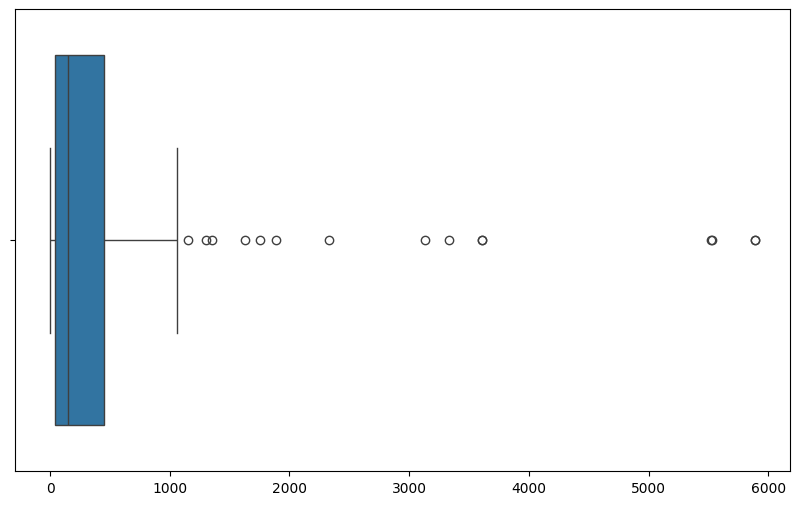

In [19]:
# Length of each reviews
plt.figure(figsize=(10,6))
review_len = [len(d) for d in data['pos']]
sns.boxplot(review_len, orient='h')
plt.show()

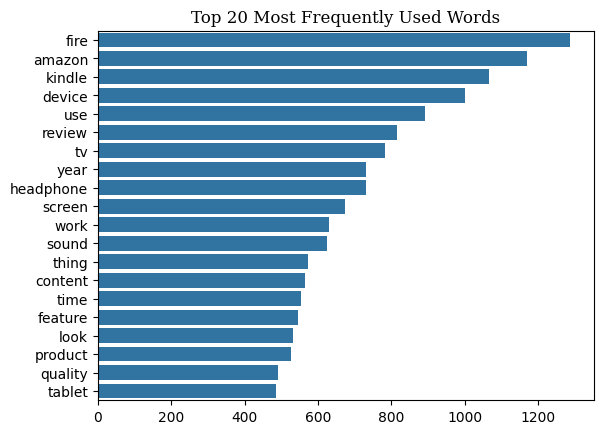

In [20]:
# Top 20 most frequent words
all_words = ' '.join(data['pos'].values).split()
word_count = Counter(all_words)
words_df = pd.DataFrame(word_count.most_common(20),
                        columns=['word','count'])

sns.barplot(data=words_df, x='count', y='word')
plt.title('Top 20 Most Frequently Used Words', family='serif')
plt.xlabel('')
plt.ylabel('')
plt.show()

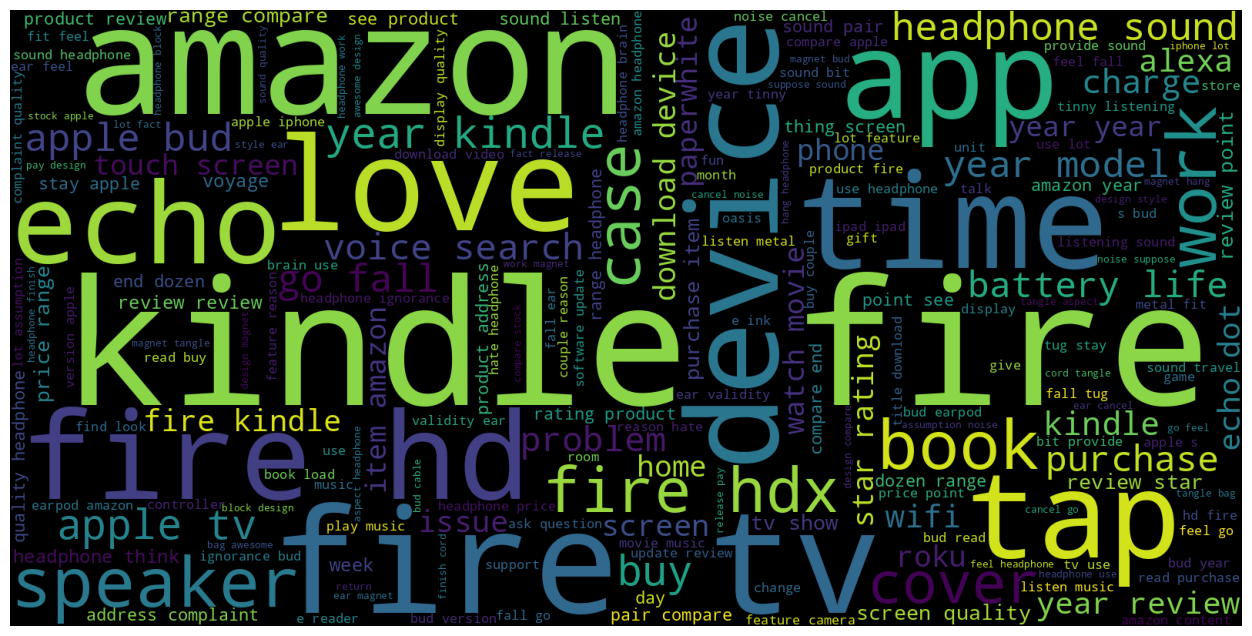

In [21]:
# Word Cloud
plt.figure(figsize=(18,8))
wordcloud = WordCloud(height=800, width=1600).generate(' '.join(data['pos']))
plt.axis('off')
plt.imshow(wordcloud)

Unigrams, Bigrams, Trigrams

In [22]:
# function to control n_grams
def get_top_ngrams(text, n_gram=1, top=None):
  vectorizer = CountVectorizer(ngram_range=(n_gram, n_gram), stop_words='english')
  bow = vectorizer.fit_transform(text)

  sum_of_words = bow.sum(axis=0)
  word_freq = [(word, sum_of_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

  word_freq = sorted(word_freq, key=lambda x:x[1], reverse=True)
  return word_freq[:top]

In [23]:
# generating n_grams
top_30_unigram = get_top_ngrams(data['pos'], top=30)
top_30_bigrams = get_top_ngrams(data['pos'], n_gram=2, top=30)
top_30_trigrams = get_top_ngrams(data['pos'], n_gram=3, top=30)

In [24]:
print('Top 10 Unigram:\n')
top_30_unigram[:10]

Top 10 Unigram:



[('amazon', np.int64(1171)),
 ('kindle', np.int64(1066)),
 ('device', np.int64(1000)),
 ('use', np.int64(891)),
 ('review', np.int64(815)),
 ('tv', np.int64(782)),
 ('year', np.int64(732)),
 ('headphone', np.int64(730)),
 ('screen', np.int64(674)),
 ('work', np.int64(630))]

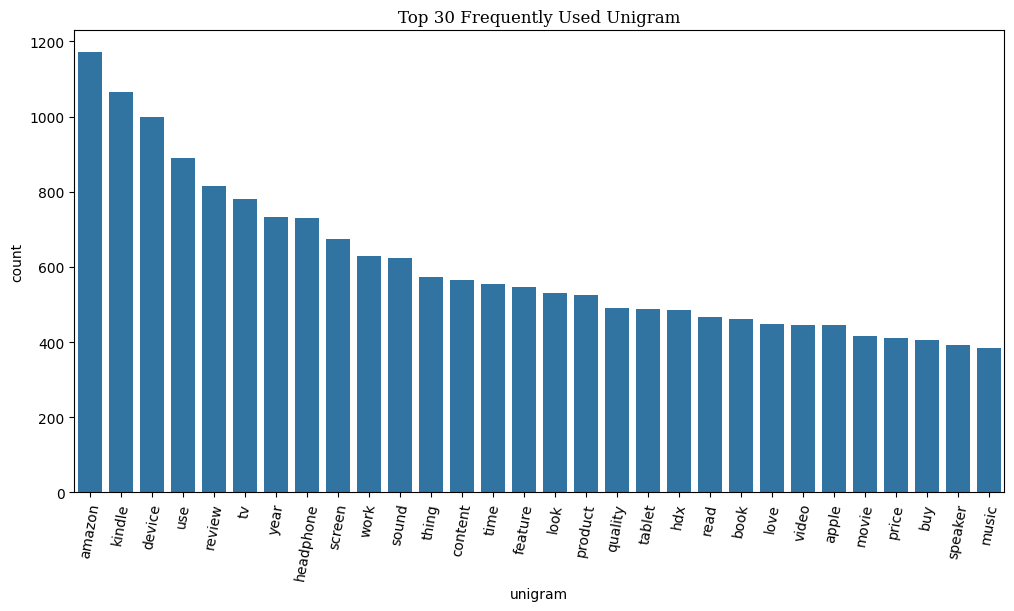

In [25]:
# ploting graph of unigrams
df1 = pd.DataFrame(top_30_unigram, columns=['unigram','count'])
plt.figure(figsize=(12,6))
sns.barplot(data=df1, x='unigram', y='count')
plt.title('Top 30 Frequently Used Unigram', family='serif')
plt.xticks(rotation=80)
plt.show()

In [26]:
print('Top 10 Bigrams:\n')
top_30_bigrams[:10]

Top 10 Bigrams:



[('apple bud', np.int64(177)),
 ('year kindle', np.int64(129)),
 ('kindle hd', np.int64(127)),
 ('apple tv', np.int64(122)),
 ('headphone sound', np.int64(119)),
 ('feel fall', np.int64(117)),
 ('year model', np.int64(111)),
 ('battery life', np.int64(104)),
 ('voice search', np.int64(101)),
 ('kindle kindle', np.int64(85))]

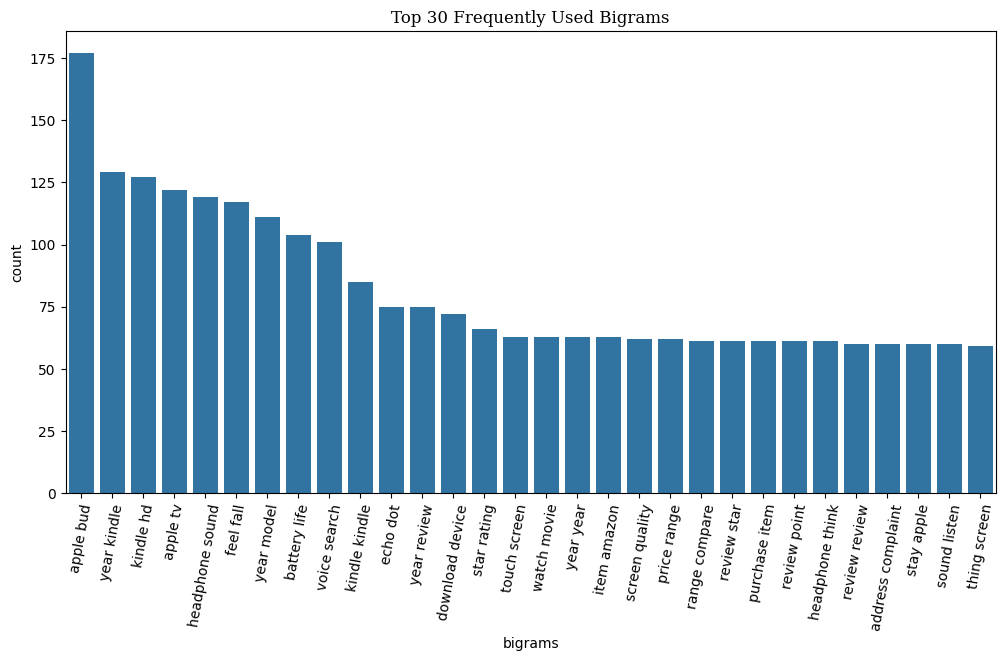

In [27]:
# ploting graph of bigrams
df2 = pd.DataFrame(top_30_bigrams, columns=['bigrams','count'])
plt.figure(figsize=(12,6))
sns.barplot(data=df2, x='bigrams', y='count')
plt.title('Top 30 Frequently Used Bigrams', family='serif')
plt.xticks(rotation=80)
plt.show()

In [28]:
print('Top 10 Trigrams:\n')
top_30_trigrams[:10]

Top 10 Trigrams:



[('purchase item amazon', np.int64(60)),
 ('item amazon year', np.int64(59)),
 ('amazon year review', np.int64(59)),
 ('year review review', np.int64(59)),
 ('review review point', np.int64(59)),
 ('review point product', np.int64(59)),
 ('point product review', np.int64(59)),
 ('product review star', np.int64(59)),
 ('review star rating', np.int64(59)),
 ('star rating product', np.int64(59))]

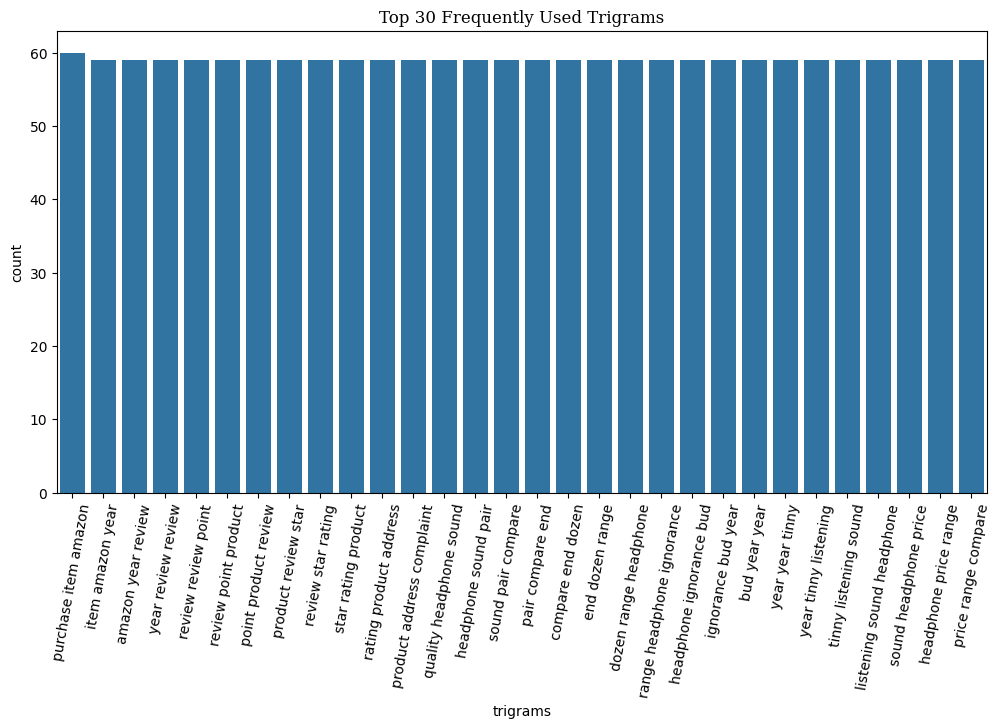

In [29]:
# ploting graph of trigrams
df3 = pd.DataFrame(top_30_trigrams, columns=['trigrams','count'])
plt.figure(figsize=(12,6))
sns.barplot(data=df3, x='trigrams', y='count')
plt.title('Top 30 Frequently Used Trigrams', family='serif')
plt.xticks(rotation=80)
plt.show()

### Sentiment Analysis

In [30]:
# function to find the sentiment of review
def get_sentiment(text):
  return TextBlob(text).sentiment.polarity

In [31]:
# apply get_sentiment function to dataset
data['sentiment_score'] = data['clean_reviews'].apply(lambda x:get_sentiment(x))

# data sample
data.head()

,Reviews,Title,clean_reviews,lemma,pos,sentiment_score
0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",i initially had trouble deciding between the p...,initially trouble decide paperwhite voyage rev...,trouble voyage review say thing paperwhite spe...,0.208061
1,Allow me to preface this with a little history...,One Simply Could Not Ask For More,allow me to preface this with a little history...,allow preface little history casual reader own...,allow preface history reader touch world title...,0.156675
2,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,i am enjoying it so far great for reading had ...,enjoy far great read original fire fire eye ...,enjoy fire fire eye hurt experience paperwhite,0.220833
3,I bought one of the first Paperwhites and have...,Love / Hate relationship,i bought one of the first paperwhites and have...,buy paperwhite pleased constant companion supp...,buy companion read book day year finger reason...,0.143352
4,I have to say upfront - I don't like coroporat...,I LOVE IT,i have to say upfront i do not like coroporate...,upfront like coroporate hermetically closed st...,stuff apple case amazon device want use user y...,0.270584


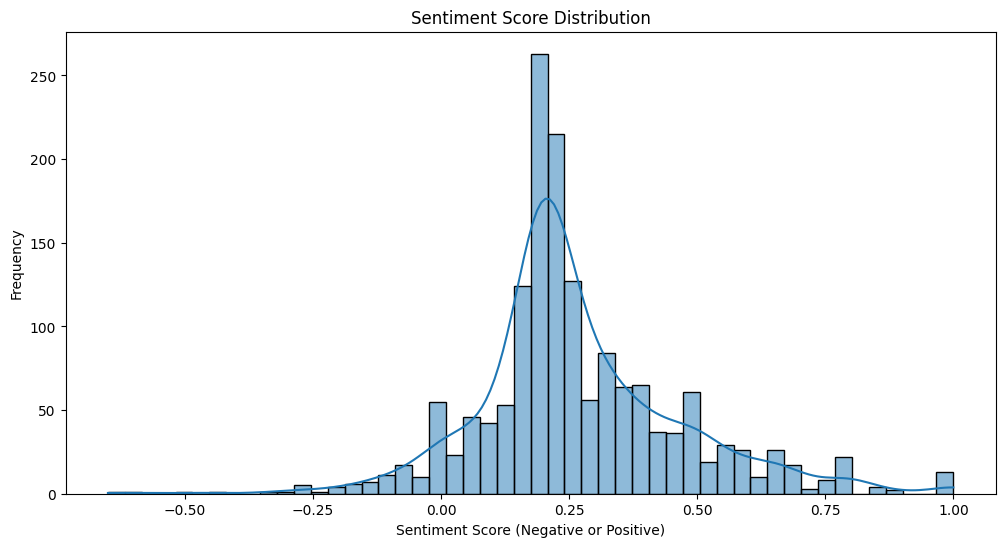

In [32]:
# plotting sentiment score
plt.figure(figsize=(12,6))
sns.histplot(data=data, x='sentiment_score', kde=True, bins=50)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score (Negative or Positive)')
plt.ylabel('Frequency')
plt.show()

### Topic Modelling

In [33]:
# convert raw text into tf-idf features
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
review_matrix = tfidf.fit_transform(data['pos'])

In [34]:
# first 10 features name
tfidf.get_feature_names_out()[:10]

array(['aa', 'ability', 'abit', 'accent', 'access', 'accessibility',
       'accessory', 'accord', 'account', 'accuracy'], dtype=object)

In [35]:
# vocabulary
len(tfidf.get_feature_names_out())

1643

Non-Negative Matrix Factorization (NMF)

In [36]:
num_topic = 4
nmf = NMF(n_components=num_topic, random_state=42)
w1 = nmf.fit_transform(review_matrix)
h1 = nmf.components_

In [37]:
# printing the top 15 words of each topic
num_words = 15
vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda x: [vocab[i] for i in np.argsort(x)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in h1])
topics = [' '.join(t) for t in topic_words]

In [38]:
topics

# Kindle / Tablets - 0
# Headphone / Buds - 1
# Speaker / Alexa - 2
# TV / Roku - 3

['kindle year device review ipad hd tablet model hdx screen book reader display feature user',
 'headphone bud sound apple fall ear feel magnet compare design range year review product earpod',
 'tap speaker love echo music dot sound use work alexa buy voice button charge amazon',
 'tv movie content amazon search roku comcast watch game look apple use thing option prime']

In [39]:
# assigning dominant topic to each review
colnames = ['Topic_'+str(i) for i in range(nmf.n_components_)]
docnames = ['Doc_'+str(i) for i in range(len(data['pos']))]
df_topic = pd.DataFrame(np.round(w1,3), columns=colnames, index=docnames)

significant_topic = np.argmax(df_topic.values, axis=1)
df_topic['dominant_topic'] = significant_topic

# sample
df_topic.sample(10)

,Topic_0,Topic_1,Topic_2,Topic_3,dominant_topic
Doc_1181,0.000,0.000,0.060,0.038,2
Doc_734,0.133,0.000,0.000,0.014,0
Doc_262,0.058,0.002,0.002,0.000,0
Doc_1276,0.013,0.002,0.114,0.043,2
Doc_594,0.097,0.027,0.011,0.055,0
Doc_1572,0.000,0.012,0.018,0.110,3
Doc_1524,0.000,0.257,0.000,0.000,1
Doc_654,0.005,0.000,0.128,0.005,2
Doc_456,0.012,0.003,0.025,0.011,2
Doc_670,0.080,0.015,0.026,0.020,0


In [40]:
# assigning topic to dataset
data['Topic'] = significant_topic

# data sample
final_data = data[['clean_reviews','Topic']]
final_data.sample(5)

,clean_reviews,Topic
780,this review is for the second generation kindl...,0
141,updated one year in this review is for the t...,3
869,we now have one for everyone in the family and...,2
1118,can charge and take anywhere in the house hold...,2
272,i have owned literally and i mean literally ev...,0


In [41]:
# manual topic mapping
topic_mapping = {
    0: 'Kindle / Tablet',
    1: 'Headphone / Buds',
    2: 'Speaker / Alexa',
    3: 'TV / Roku'
}

final_data['Topic'] = final_data['Topic'].map(topic_mapping)

# data sample
final_data.sample(5)

,clean_reviews,Topic
1347,this is my second echo purchase my first was t...,Speaker / Alexa
1034,i am enjoying the tap very much lot s to do an...,Speaker / Alexa
1320,good price travels well has a lot of good feat...,TV / Roku
81,an amazon com official commented on this revie...,TV / Roku
1003,i would recommend this prouducts it had great ...,Headphone / Buds


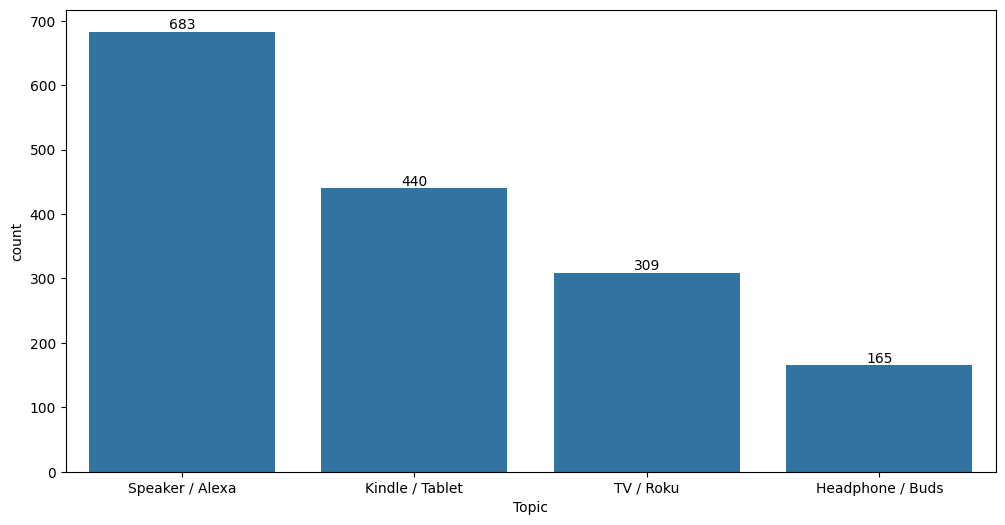

In [42]:
# checking topic distribution
plt.figure(figsize=(12,6))
ax = sns.countplot(data=final_data, x='Topic', order=final_data['Topic'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.show()

### Processing for Supervised Model

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import *
from keras.layers import *

from sklearn.model_selection import train_test_split

In [44]:
# create a copy to final data
final_df = final_data.copy()

# data sample
final_df.sample(5)

,clean_reviews,Topic
872,got as a gift might not have got for my self b...,Speaker / Alexa
530,my primary concern is the price when comparing...,Kindle / Tablet
737,this is the fifth e ink kindle reader that i h...,Kindle / Tablet
21,i already had an original kindle paperwhite an...,Kindle / Tablet
1325,i read the reviews and even listened to this i...,Headphone / Buds


In [45]:
# convert the target variable to numeric
label2id = {
    'Kindle / Tablet' : 0,
    'Headphone / Buds' : 1,
    'Speaker / Alexa' : 2,
    'TV / Roku' : 3
}

final_df['Label'] = final_df['Topic'].map(label2id)
final_df.drop('Topic', axis=1, inplace=True)

# data sample
final_df.sample(5)

,clean_reviews,Label
1110,bought the tap for my mom to primarily listen ...,2
1424,i own the merlot cover since it came with my k...,0
152,major fan did not buy this because of protecti...,0
1217,love the sound that comes out and alexa is ver...,2
1413,originally got the walnut cover with my oasis ...,2


In [46]:
# split into train & test
x_train, x_test, y_train, y_test = train_test_split(final_df['clean_reviews'], final_df['Label'],
                                                    test_size=0.2, random_state=42, stratify=final_df['Label'])

# shape
print(x_train.shape)
print(x_test.shape)

(1277,)
(320,)


In [47]:
# convert text into numeric representation
x_tokenizer = Tokenizer(oov_token='<unknown>')
x_tokenizer.fit_on_texts(x_train)

In [48]:
vocab = len(x_tokenizer.word_index)
print(f'{vocab} - Unique vocabulary')

5763 - Unique vocabulary


In [49]:
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

In [50]:
# add padding - to make each sentence equal length
max_len = 200
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

In [51]:
x_train_pad[0]

array([ 668, 2099, 1322, 1415,  976,  231, 1566, 1323, 1324, 1325, 1567,
       1322, 2100,   31, 1323, 1566,  976,  976, 1323,  456, 1655,  976,
       1513, 2101,   31,  976, 1325, 1567, 1322, 2102,  456, 2103, 2104,
       1325, 2105,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [52]:
x_train_pad[65]

array([823,  21,   2, 373, 674,  11, 861,  96, 238,   5, 722,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [53]:
# Convert target to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [54]:
y_train

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

### Model Building

In [55]:
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=vocab+1, output_dim=50, input_length=max_len, mask_zero=True, trainable=True))

# LSTM
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))

# Output Layer
model.add(Dense(4, activation='softmax'))

# Model Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Fit
history = model.fit(x_train_pad, y_train, validation_data=(x_test_pad, y_test), epochs=5)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - accuracy: 0.4037 - loss: 1.3094 - val_accuracy: 0.6250 - val_loss: 0.9396
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.7666 - loss: 0.7549 - val_accuracy: 0.8250 - val_loss: 0.5245
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - accuracy: 0.9034 - loss: 0.3578 - val_accuracy: 0.8375 - val_loss: 0.4662
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 274ms/step - accuracy: 0.9504 - loss: 0.1792 - val_accuracy: 0.8344 - val_loss: 0.4197
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - accuracy: 0.9767 - loss: 0.1009 - val_accuracy: 0.8344 - val_loss: 0.4494
